# Introduction

For this project I will be participating in the Natural Language Processing with Disaster Tweets Kaggle competition. The purpose of this project is to train a recurrent neural network (RNN) which will be capable of classifying a tweet as being about a disaster or not.

The training data has $7,613$ entries, which consist of an `id`, `keyword`, `location`, `text`, and `target`. The key feature I will be considering is `text`, which is a string containing the content of the tweet in question. `Target` is either $1$ if the tweet is about a disaster or $0$ if it is not.

# EDA and Cleaning

The code below loads the data and vectorizes it. I trained models using both a CountVectorizer and TF-IDF, but the CountVectorizer proved to have better performance. Only the top $100$ most frequent words are considered.

The data is clean.

In [16]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [17]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [20]:
max_features=100
count_vectorizer = feature_extraction.text.CountVectorizer(max_features=max_features)

In [21]:
#create vectors from raw data
train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

#convert sparse matrices to dense
train_vectors_d = train_vectors.todense()
test_vectors_d = test_vectors.todense()

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Dropout, Masking, Embedding

batch_size = 64
epochs = 20

#binary classification problem requires this
num_classes=1

embedding_vector_length = 32

In [23]:
from sklearn.model_selection import train_test_split

X_train,valid_X,train_label,valid_label = train_test_split(train_vectors_d, train_df['target'], test_size=0.2, random_state=4)

In [24]:
#convert to tensors for training
train_vectors_t = tf.constant(X_train)
valid_X_t = tf.constant(valid_X)
test_vectors_t = tf.constant(test_vectors_d)

# Model architecture

I iterate through several architectures below to maximize accuracy.

First, there is an embedding layer. Initially I did not include a dropout layer, but later I add one to combat overfitting after scrutinizing the graphs below. I tried training models using both an LSTM layer and a GRU layer but there was no significant difference in performance. Then I include a second dropout layer. The final dense layer is for classification, and since this is a binary classification problem, I opted to use the sigmoid activation function.

Initially, the batch size is $64$, and I train the model for $20$ epochs. I increase this over time to a batch size of $2048$, and ultimately $100$ epochs proved best for the final model performance.

In [25]:
model = Sequential()
model.add(Embedding(max_features,embedding_vector_length))
#model.add(Dropout(0.2))
model.add(LSTM(max_features))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [26]:
train = model.fit(train_vectors_t, train_label,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X_t, valid_label))

Epoch 1/20
96/96 [==============================] - 4s 22ms/step - loss: 0.6834 - accuracy: 0.5677 - val_loss: 0.6775 - val_accuracy: 0.5772
Epoch 2/20
96/96 [==============================] - 2s 17ms/step - loss: 0.6721 - accuracy: 0.5663 - val_loss: 0.6746 - val_accuracy: 0.5575
Epoch 3/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6676 - accuracy: 0.5660 - val_loss: 0.6725 - val_accuracy: 0.5850
Epoch 4/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6670 - accuracy: 0.5650 - val_loss: 0.6698 - val_accuracy: 0.5798
Epoch 5/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6661 - accuracy: 0.5673 - val_loss: 0.6694 - val_accuracy: 0.5772
Epoch 6/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6645 - accuracy: 0.5673 - val_loss: 0.6706 - val_accuracy: 0.5548
Epoch 7/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6642 - accuracy: 0.5701 - val_loss: 0.6673 - val_accuracy: 0.5758
Epoch 8/20
96

In [27]:
#create output .csv to submit to kaggle
def output():
    test_y = model.predict(test_vectors_t)
    target=[]
    for y in test_y:
        if y > 0.5:
            target.append(1)
        else:
            target.append(0)
    out = pd.DataFrame({'id' : test_df['id'], 'target':target})
    output = out.to_csv('output1.csv',index=False)

output()

102/102 [==============================] - 1s 4ms/step


In [28]:
#plot loss and accuracy for training and validation data
loss = train.history['loss']
acc = train.history['accuracy']
v_loss = train.history['val_loss']
v_acc = train.history['val_accuracy']
n_epochs = range(epochs)

Text(0, 0.5, 'Loss')

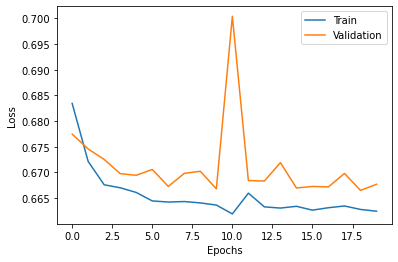

In [29]:
from matplotlib import pyplot as plt
plt.plot(n_epochs, loss, label='Train')
plt.plot(n_epochs, v_loss, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

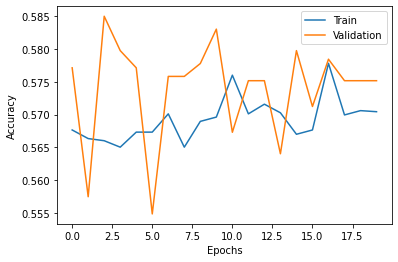

In [30]:
plt.plot(n_epochs, acc, label='Train')
plt.plot(n_epochs, v_acc, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

I decided to train the model for more epochs here to improve the performance.

In [31]:
#increase batch size/epochs
batch_size = 128
epochs = 500

train = model.fit(train_vectors_t, train_label,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X_t, valid_label))

output()

loss = train.history['loss']
acc = train.history['accuracy']
v_loss = train.history['val_loss']
v_acc = train.history['val_accuracy']
n_epochs = range(epochs)

Epoch 1/500
48/48 [==============================] - 1s 17ms/step - loss: 0.6618 - accuracy: 0.5727 - val_loss: 0.6682 - val_accuracy: 0.5798
Epoch 2/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6611 - accuracy: 0.5693 - val_loss: 0.6681 - val_accuracy: 0.5739
Epoch 3/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6609 - accuracy: 0.5700 - val_loss: 0.6674 - val_accuracy: 0.5634
Epoch 4/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6601 - accuracy: 0.5700 - val_loss: 0.6674 - val_accuracy: 0.5791
Epoch 5/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6568 - accuracy: 0.5933 - val_loss: 0.6598 - val_accuracy: 0.5936
Epoch 6/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6502 - accuracy: 0.6018 - val_loss: 0.6565 - val_accuracy: 0.6106
Epoch 7/500
48/48 [==============================] - 1s 16ms/step - loss: 0.6378 - accuracy: 0.6356 - val_loss: 0.6472 - val_accuracy: 0.6041
Epoch 

48/48 [==============================] - 1s 16ms/step - loss: 0.5783 - accuracy: 0.6952 - val_loss: 0.6217 - val_accuracy: 0.6770
Epoch 59/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5722 - accuracy: 0.6993 - val_loss: 0.6259 - val_accuracy: 0.6605
Epoch 60/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5689 - accuracy: 0.7000 - val_loss: 0.6256 - val_accuracy: 0.6599
Epoch 61/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5668 - accuracy: 0.7072 - val_loss: 0.6455 - val_accuracy: 0.6559
Epoch 62/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5649 - accuracy: 0.7048 - val_loss: 0.6289 - val_accuracy: 0.6822
Epoch 63/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5667 - accuracy: 0.6982 - val_loss: 0.6299 - val_accuracy: 0.6776
Epoch 64/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5561 - accuracy: 0.7130 - val_loss: 0.6312 - val_accuracy: 0.6632
Epoch 65/500

48/48 [==============================] - 1s 16ms/step - loss: 0.4721 - accuracy: 0.7655 - val_loss: 0.6831 - val_accuracy: 0.6724
Epoch 116/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4529 - accuracy: 0.7773 - val_loss: 0.6955 - val_accuracy: 0.6559
Epoch 117/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4554 - accuracy: 0.7704 - val_loss: 0.6938 - val_accuracy: 0.6671
Epoch 118/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4543 - accuracy: 0.7787 - val_loss: 0.7187 - val_accuracy: 0.6737
Epoch 119/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4703 - accuracy: 0.7696 - val_loss: 0.6990 - val_accuracy: 0.6619
Epoch 120/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4608 - accuracy: 0.7719 - val_loss: 0.6889 - val_accuracy: 0.6678
Epoch 121/500
48/48 [==============================] - 1s 16ms/step - loss: 0.4449 - accuracy: 0.7823 - val_loss: 0.7167 - val_accuracy: 0.6717
Epoch 

Epoch 172/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3587 - accuracy: 0.8271 - val_loss: 0.8196 - val_accuracy: 0.6625
Epoch 173/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3688 - accuracy: 0.8258 - val_loss: 0.8782 - val_accuracy: 0.6632
Epoch 174/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3750 - accuracy: 0.8199 - val_loss: 0.8519 - val_accuracy: 0.6513
Epoch 175/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3506 - accuracy: 0.8402 - val_loss: 0.8973 - val_accuracy: 0.6579
Epoch 176/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3875 - accuracy: 0.8177 - val_loss: 0.8395 - val_accuracy: 0.6520
Epoch 177/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3805 - accuracy: 0.8190 - val_loss: 0.8276 - val_accuracy: 0.6678
Epoch 178/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3447 - accuracy: 0.8335 - val_loss: 0.8919 - val_accuracy:

Epoch 229/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3019 - accuracy: 0.8635 - val_loss: 0.9890 - val_accuracy: 0.6389
Epoch 230/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2892 - accuracy: 0.8672 - val_loss: 0.9814 - val_accuracy: 0.6454
Epoch 231/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2861 - accuracy: 0.8649 - val_loss: 0.9840 - val_accuracy: 0.6408
Epoch 232/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3313 - accuracy: 0.8458 - val_loss: 0.9531 - val_accuracy: 0.6428
Epoch 233/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3056 - accuracy: 0.8599 - val_loss: 1.0159 - val_accuracy: 0.6513
Epoch 234/500
48/48 [==============================] - 1s 16ms/step - loss: 0.3479 - accuracy: 0.8374 - val_loss: 0.9900 - val_accuracy: 0.6494
Epoch 235/500
48/48 [==============================] - 1s 19ms/step - loss: 0.3118 - accuracy: 0.8524 - val_loss: 0.9811 - val_accuracy:

Epoch 286/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2809 - accuracy: 0.8677 - val_loss: 1.0573 - val_accuracy: 0.6441
Epoch 287/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2723 - accuracy: 0.8729 - val_loss: 1.0446 - val_accuracy: 0.6435
Epoch 288/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2914 - accuracy: 0.8622 - val_loss: 1.0231 - val_accuracy: 0.6507
Epoch 289/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2970 - accuracy: 0.8649 - val_loss: 1.0047 - val_accuracy: 0.6382
Epoch 290/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2949 - accuracy: 0.8622 - val_loss: 0.9935 - val_accuracy: 0.6513
Epoch 291/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2651 - accuracy: 0.8747 - val_loss: 1.0690 - val_accuracy: 0.6533
Epoch 292/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2378 - accuracy: 0.8928 - val_loss: 1.0778 - val_accuracy:

Epoch 343/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2733 - accuracy: 0.8782 - val_loss: 1.0868 - val_accuracy: 0.6448
Epoch 344/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2977 - accuracy: 0.8647 - val_loss: 1.1854 - val_accuracy: 0.6494
Epoch 345/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2671 - accuracy: 0.8765 - val_loss: 1.1339 - val_accuracy: 0.6467
Epoch 346/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2419 - accuracy: 0.8913 - val_loss: 1.1861 - val_accuracy: 0.6586
Epoch 347/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2133 - accuracy: 0.9038 - val_loss: 1.1835 - val_accuracy: 0.6428
Epoch 348/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2267 - accuracy: 0.8970 - val_loss: 1.1056 - val_accuracy: 0.6546
Epoch 349/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2917 - accuracy: 0.8701 - val_loss: 1.1402 - val_accuracy:

Epoch 400/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1874 - accuracy: 0.9138 - val_loss: 1.2525 - val_accuracy: 0.6454
Epoch 401/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1904 - accuracy: 0.9130 - val_loss: 1.2897 - val_accuracy: 0.6533
Epoch 402/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1987 - accuracy: 0.9107 - val_loss: 1.2325 - val_accuracy: 0.6566
Epoch 403/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2077 - accuracy: 0.9021 - val_loss: 1.2689 - val_accuracy: 0.6461
Epoch 404/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1950 - accuracy: 0.9130 - val_loss: 1.2635 - val_accuracy: 0.6566
Epoch 405/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1962 - accuracy: 0.9128 - val_loss: 1.3205 - val_accuracy: 0.6435
Epoch 406/500
48/48 [==============================] - 1s 16ms/step - loss: 0.2561 - accuracy: 0.8844 - val_loss: 1.2777 - val_accuracy:

Epoch 457/500
48/48 [==============================] - 1s 20ms/step - loss: 0.1700 - accuracy: 0.9204 - val_loss: 1.3404 - val_accuracy: 0.6382
Epoch 458/500
48/48 [==============================] - 1s 17ms/step - loss: 0.1671 - accuracy: 0.9230 - val_loss: 1.3787 - val_accuracy: 0.6343
Epoch 459/500
48/48 [==============================] - 1s 19ms/step - loss: 0.1695 - accuracy: 0.9218 - val_loss: 1.3687 - val_accuracy: 0.6198
Epoch 460/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2358 - accuracy: 0.8972 - val_loss: 1.3076 - val_accuracy: 0.6422
Epoch 461/500
48/48 [==============================] - 1s 17ms/step - loss: 0.1957 - accuracy: 0.9113 - val_loss: 1.3355 - val_accuracy: 0.6395
Epoch 462/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2339 - accuracy: 0.8956 - val_loss: 1.2569 - val_accuracy: 0.6395
Epoch 463/500
48/48 [==============================] - 1s 20ms/step - loss: 0.2075 - accuracy: 0.9074 - val_loss: 1.3188 - val_accuracy:

Text(0, 0.5, 'Loss')

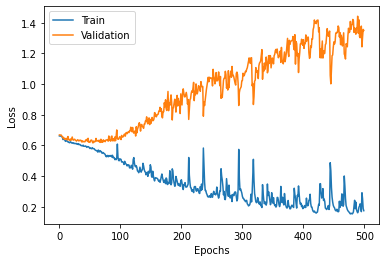

In [32]:
plt.plot(n_epochs, loss, label='Train')
plt.plot(n_epochs, v_loss, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

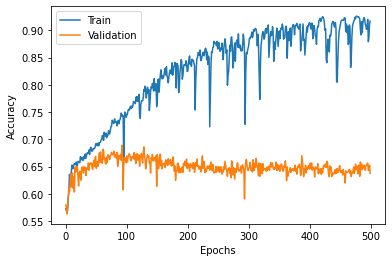

In [33]:
plt.plot(n_epochs, acc, label='Train')
plt.plot(n_epochs, v_acc, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Note how the train and validation accuracy and loss diverge over time, indicating overfitting. Therefore I add dropout layers in the model below.

In [34]:
model = Sequential()
model.add(Embedding(max_features,embedding_vector_length))
model.add(Dropout(0.2))
model.add(LSTM(max_features))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

batch_size = 128
epochs = 500

train = model.fit(train_vectors_t, train_label,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X_t, valid_label))

test_y = model.predict(test_vectors_t)
target=[]
for y in test_y:
    if y > 0.5:
        target.append(1)
    else:
        target.append(0)
out = pd.DataFrame({'id' : test_df['id'], 'target':target})
output = out.to_csv('output2.csv',index=False)

loss = train.history['loss']
acc = train.history['accuracy']
v_loss = train.history['val_loss']
v_acc = train.history['val_accuracy']
n_epochs = range(epochs)

Epoch 1/500
48/48 [==============================] - 3s 28ms/step - loss: 0.6857 - accuracy: 0.5616 - val_loss: 0.6816 - val_accuracy: 0.5772
Epoch 2/500
48/48 [==============================] - 1s 24ms/step - loss: 0.6825 - accuracy: 0.5686 - val_loss: 0.6800 - val_accuracy: 0.5772
Epoch 3/500
48/48 [==============================] - 1s 28ms/step - loss: 0.6781 - accuracy: 0.5686 - val_loss: 0.6746 - val_accuracy: 0.5824
Epoch 4/500
48/48 [==============================] - 1s 25ms/step - loss: 0.6681 - accuracy: 0.5765 - val_loss: 0.6736 - val_accuracy: 0.5666
Epoch 5/500
48/48 [==============================] - 1s 23ms/step - loss: 0.6701 - accuracy: 0.5698 - val_loss: 0.6719 - val_accuracy: 0.5693
Epoch 6/500
48/48 [==============================] - 1s 23ms/step - loss: 0.6651 - accuracy: 0.5734 - val_loss: 0.6690 - val_accuracy: 0.5752
Epoch 7/500
48/48 [==============================] - 1s 27ms/step - loss: 0.6653 - accuracy: 0.5785 - val_loss: 0.6697 - val_accuracy: 0.5778
Epoch 

48/48 [==============================] - 1s 23ms/step - loss: 0.6068 - accuracy: 0.6721 - val_loss: 0.6385 - val_accuracy: 0.6362
Epoch 59/500
48/48 [==============================] - 1s 31ms/step - loss: 0.6055 - accuracy: 0.6714 - val_loss: 0.6271 - val_accuracy: 0.6540
Epoch 60/500
48/48 [==============================] - 1s 18ms/step - loss: 0.6073 - accuracy: 0.6721 - val_loss: 0.6336 - val_accuracy: 0.6467
Epoch 61/500
48/48 [==============================] - 1s 18ms/step - loss: 0.6084 - accuracy: 0.6724 - val_loss: 0.6231 - val_accuracy: 0.6507
Epoch 62/500
48/48 [==============================] - 2s 34ms/step - loss: 0.6018 - accuracy: 0.6808 - val_loss: 0.6233 - val_accuracy: 0.6474
Epoch 63/500
48/48 [==============================] - 1s 17ms/step - loss: 0.5955 - accuracy: 0.6860 - val_loss: 0.6234 - val_accuracy: 0.6474
Epoch 64/500
48/48 [==============================] - 1s 22ms/step - loss: 0.5943 - accuracy: 0.6846 - val_loss: 0.6207 - val_accuracy: 0.6487
Epoch 65/500

48/48 [==============================] - 1s 19ms/step - loss: 0.5647 - accuracy: 0.7112 - val_loss: 0.6327 - val_accuracy: 0.6500
Epoch 116/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5676 - accuracy: 0.7043 - val_loss: 0.6120 - val_accuracy: 0.6776
Epoch 117/500
48/48 [==============================] - 1s 18ms/step - loss: 0.5652 - accuracy: 0.7103 - val_loss: 0.6163 - val_accuracy: 0.6678
Epoch 118/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5581 - accuracy: 0.7122 - val_loss: 0.6142 - val_accuracy: 0.6737
Epoch 119/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5711 - accuracy: 0.7051 - val_loss: 0.6124 - val_accuracy: 0.6756
Epoch 120/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5553 - accuracy: 0.7138 - val_loss: 0.6220 - val_accuracy: 0.6566
Epoch 121/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5512 - accuracy: 0.7210 - val_loss: 0.6178 - val_accuracy: 0.6664
Epoch 

Epoch 172/500
48/48 [==============================] - 1s 18ms/step - loss: 0.5158 - accuracy: 0.7425 - val_loss: 0.6378 - val_accuracy: 0.6730
Epoch 173/500
48/48 [==============================] - 1s 18ms/step - loss: 0.5080 - accuracy: 0.7448 - val_loss: 0.6300 - val_accuracy: 0.6599
Epoch 174/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4895 - accuracy: 0.7594 - val_loss: 0.6551 - val_accuracy: 0.6553
Epoch 175/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4920 - accuracy: 0.7547 - val_loss: 0.6592 - val_accuracy: 0.6592
Epoch 176/500
48/48 [==============================] - 1s 18ms/step - loss: 0.5034 - accuracy: 0.7544 - val_loss: 0.6552 - val_accuracy: 0.6691
Epoch 177/500
48/48 [==============================] - 1s 19ms/step - loss: 0.5020 - accuracy: 0.7479 - val_loss: 0.6498 - val_accuracy: 0.6592
Epoch 178/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4920 - accuracy: 0.7570 - val_loss: 0.6538 - val_accuracy:

Epoch 229/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4514 - accuracy: 0.7831 - val_loss: 0.7100 - val_accuracy: 0.6527
Epoch 230/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4363 - accuracy: 0.7872 - val_loss: 0.7331 - val_accuracy: 0.6586
Epoch 231/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4519 - accuracy: 0.7782 - val_loss: 0.7016 - val_accuracy: 0.6638
Epoch 232/500
48/48 [==============================] - 1s 18ms/step - loss: 0.4454 - accuracy: 0.7782 - val_loss: 0.7097 - val_accuracy: 0.6579
Epoch 233/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4225 - accuracy: 0.7946 - val_loss: 0.7349 - val_accuracy: 0.6664
Epoch 234/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4384 - accuracy: 0.7892 - val_loss: 0.7347 - val_accuracy: 0.6461
Epoch 235/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4243 - accuracy: 0.7949 - val_loss: 0.7414 - val_accuracy:

Epoch 286/500
48/48 [==============================] - 1s 19ms/step - loss: 0.3722 - accuracy: 0.8273 - val_loss: 0.8207 - val_accuracy: 0.6389
Epoch 287/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4116 - accuracy: 0.8038 - val_loss: 0.7834 - val_accuracy: 0.6376
Epoch 288/500
48/48 [==============================] - 1s 20ms/step - loss: 0.4524 - accuracy: 0.7823 - val_loss: 0.7698 - val_accuracy: 0.6553
Epoch 289/500
48/48 [==============================] - 1s 19ms/step - loss: 0.3936 - accuracy: 0.8164 - val_loss: 0.7558 - val_accuracy: 0.6625
Epoch 290/500
48/48 [==============================] - 1s 18ms/step - loss: 0.3914 - accuracy: 0.8194 - val_loss: 0.7971 - val_accuracy: 0.6316
Epoch 291/500
48/48 [==============================] - 1s 19ms/step - loss: 0.4216 - accuracy: 0.8011 - val_loss: 0.8188 - val_accuracy: 0.6323
Epoch 292/500
48/48 [==============================] - 1s 20ms/step - loss: 0.4201 - accuracy: 0.7985 - val_loss: 0.8210 - val_accuracy:

Epoch 343/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3314 - accuracy: 0.8501 - val_loss: 0.9423 - val_accuracy: 0.6408
Epoch 344/500
48/48 [==============================] - 1s 18ms/step - loss: 0.3173 - accuracy: 0.8548 - val_loss: 0.9798 - val_accuracy: 0.6448
Epoch 345/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3189 - accuracy: 0.8537 - val_loss: 0.9896 - val_accuracy: 0.6487
Epoch 346/500
48/48 [==============================] - 1s 18ms/step - loss: 0.3189 - accuracy: 0.8558 - val_loss: 0.9946 - val_accuracy: 0.6494
Epoch 347/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3518 - accuracy: 0.8424 - val_loss: 0.9827 - val_accuracy: 0.6428
Epoch 348/500
48/48 [==============================] - 1s 17ms/step - loss: 0.4898 - accuracy: 0.7690 - val_loss: 0.8227 - val_accuracy: 0.6408
Epoch 349/500
48/48 [==============================] - 1s 17ms/step - loss: 0.4310 - accuracy: 0.7972 - val_loss: 0.8511 - val_accuracy:

Epoch 400/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2667 - accuracy: 0.8785 - val_loss: 1.0353 - val_accuracy: 0.6520
Epoch 401/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3717 - accuracy: 0.8343 - val_loss: 0.9270 - val_accuracy: 0.6454
Epoch 402/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3160 - accuracy: 0.8575 - val_loss: 0.9530 - val_accuracy: 0.6356
Epoch 403/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3264 - accuracy: 0.8466 - val_loss: 0.9455 - val_accuracy: 0.6664
Epoch 404/500
48/48 [==============================] - 1s 18ms/step - loss: 0.2927 - accuracy: 0.8701 - val_loss: 0.9897 - val_accuracy: 0.6586
Epoch 405/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2940 - accuracy: 0.8658 - val_loss: 1.0190 - val_accuracy: 0.6546
Epoch 406/500
48/48 [==============================] - 1s 18ms/step - loss: 0.2770 - accuracy: 0.8762 - val_loss: 1.0319 - val_accuracy:

Epoch 457/500
48/48 [==============================] - 1s 17ms/step - loss: 0.5231 - accuracy: 0.7637 - val_loss: 0.9162 - val_accuracy: 0.6376
Epoch 458/500
48/48 [==============================] - 1s 17ms/step - loss: 0.4048 - accuracy: 0.8138 - val_loss: 0.9117 - val_accuracy: 0.6408
Epoch 459/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3315 - accuracy: 0.8452 - val_loss: 1.0041 - val_accuracy: 0.6435
Epoch 460/500
48/48 [==============================] - 1s 17ms/step - loss: 0.2879 - accuracy: 0.8722 - val_loss: 1.0604 - val_accuracy: 0.6448
Epoch 461/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3426 - accuracy: 0.8419 - val_loss: 0.9181 - val_accuracy: 0.6481
Epoch 462/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3951 - accuracy: 0.8218 - val_loss: 0.9828 - val_accuracy: 0.6382
Epoch 463/500
48/48 [==============================] - 1s 17ms/step - loss: 0.3026 - accuracy: 0.8670 - val_loss: 1.0348 - val_accuracy:

Text(0, 0.5, 'Loss')

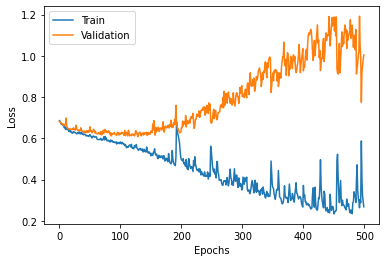

In [35]:
plt.plot(n_epochs, loss, label='Train')
plt.plot(n_epochs, v_loss, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

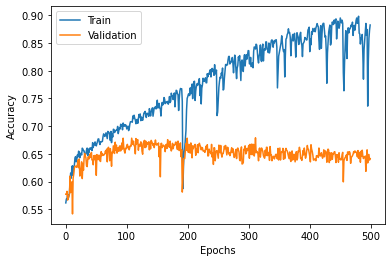

In [36]:
plt.plot(n_epochs, acc, label='Train')
plt.plot(n_epochs, v_acc, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

These plots show the accuracy and loss improve until they reach around $100$ epochs, and performance actually degrades afterwards. I train the final model for only $100$ epochs as a result.

In [37]:
model = Sequential()
model.add(Embedding(max_features,embedding_vector_length))
model.add(Dropout(0.2))
model.add(LSTM(max_features))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

#further increase batch size, and stop training once sufficient epochs have been trained
batch_size = 2048
epochs = 100

train = model.fit(train_vectors_t, train_label,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X_t, valid_label))

test_y = model.predict(test_vectors_t)
target=[]
for y in test_y:
    if y > 0.5:
        target.append(1)
    else:
        target.append(0)
out = pd.DataFrame({'id' : test_df['id'], 'target':target})
output = out.to_csv('output2.csv',index=False)

loss = train.history['loss']
acc = train.history['accuracy']
v_loss = train.history['val_loss']
v_acc = train.history['val_accuracy']
n_epochs = range(epochs)

Epoch 1/100
3/3 [==============================] - 2s 275ms/step - loss: 0.6914 - accuracy: 0.5278 - val_loss: 0.6857 - val_accuracy: 0.5772
Epoch 2/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6856 - accuracy: 0.5686 - val_loss: 0.6816 - val_accuracy: 0.5772
Epoch 3/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6847 - accuracy: 0.5686 - val_loss: 0.6817 - val_accuracy: 0.5772
Epoch 4/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6845 - accuracy: 0.5686 - val_loss: 0.6815 - val_accuracy: 0.5772
Epoch 5/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6842 - accuracy: 0.5686 - val_loss: 0.6819 - val_accuracy: 0.5772
Epoch 6/100
3/3 [==============================] - 0s 54ms/step - loss: 0.6839 - accuracy: 0.5686 - val_loss: 0.6819 - val_accuracy: 0.5772
Epoch 7/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6838 - accuracy: 0.5686 - val_loss: 0.6816 - val_accuracy: 0.5772
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 50ms/step - loss: 0.6425 - accuracy: 0.6345 - val_loss: 0.6577 - val_accuracy: 0.6244
Epoch 60/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6427 - accuracy: 0.6384 - val_loss: 0.6497 - val_accuracy: 0.6231
Epoch 61/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6430 - accuracy: 0.6332 - val_loss: 0.6493 - val_accuracy: 0.6284
Epoch 62/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6410 - accuracy: 0.6361 - val_loss: 0.6536 - val_accuracy: 0.6251
Epoch 63/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6388 - accuracy: 0.6374 - val_loss: 0.6473 - val_accuracy: 0.6251
Epoch 64/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6381 - accuracy: 0.6376 - val_loss: 0.6477 - val_accuracy: 0.6297
Epoch 65/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6374 - accuracy: 0.6396 - val_loss: 0.6509 - val_accuracy: 0.6244
Epoch 66/100
3/3 [========

Text(0, 0.5, 'Loss')

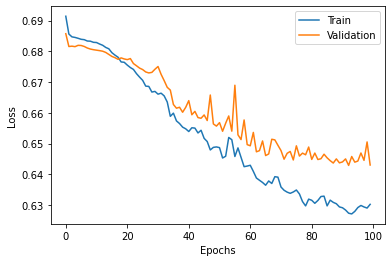

In [38]:
plt.plot(n_epochs, loss, label='Train')
plt.plot(n_epochs, v_loss, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

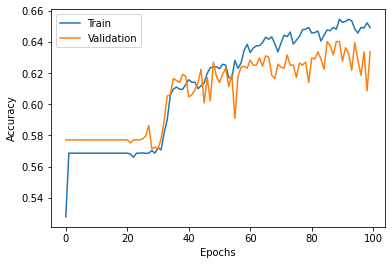

In [39]:
plt.plot(n_epochs, acc, label='Train')
plt.plot(n_epochs, v_acc, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Here my training ended. The highest test accuracy my models obtained was $0.679$.

# Conclusion

The test accuracy of my model, $0.679$, was lower than I had hoped, but there was still much to learn from this project. I found that more was not always better; limiting the number of maximum features, as well as the number of epochs for which I trained the model, both led to greater performance. Dropout layers were effective in preventing overfitting, and increasing the batch size helped with performance too. Experimenting more with embeddings might be a way to further improve the model looking forward.

# References

1.Brownlee, J. (2022, August 7). Sequence Classification with LSTM recurrent neural networks in python with keras. Machine Learning Mastery. Retrieved August 12, 2022, from https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/ 

2.Koehrsen, W. (2018, November 5). Recurrent neural networks by example in Python. Medium. Retrieved August 12, 2022, from https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470 